In [5]:
import requests
import pandas as pd

api_key = "BG644YLMMDUFXHCB"

def get_earnings_data(ticker):
    """Fetch earnings report dates from Alpha Vantage"""
    url = f"https://www.alphavantage.co/query?function=EARNINGS&symbol={ticker}&apikey={api_key}"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

    earnings_list = []

    if "quarterlyEarnings" in data:
        for entry in data["quarterlyEarnings"]:
            try:
                earnings_list.append({
                    "symbol": ticker,
                    "reported_date": pd.to_datetime(entry["reportedDate"]),
                    "actual_eps": float(entry["reportedEPS"]) if entry["reportedEPS"] != "None" else None,
                    "estimated_eps": float(entry["estimatedEPS"]) if entry["estimatedEPS"] != "None" else None,
                    "surprise": float(entry["surprise"]) if entry["surprise"] != "None" else None,
                    "surprise_pct": float(entry["surprisePercentage"]) if entry["surprisePercentage"] != "None" else None,
                })
            except KeyError as e:
                print(f"KeyError in earnings data for {ticker}: {e}")
                continue  # Skip this entry and continue with the next

    print(f"Loaded {len(earnings_list)} earnings reports for {ticker}")
    # print(f"Earning Reports: {earnings_list}")  # Remove this line for production

    return pd.DataFrame(earnings_list)


earnings_data = get_earnings_data('AAPL')
earnings_data.head()

Loaded 117 earnings reports for AAPL


,symbol,reported_date,actual_eps,estimated_eps,surprise,surprise_pct
0,AAPL,2025-05-01,NaN,1.60,0.00,NaN
1,AAPL,2025-01-30,2.40,2.35,0.05,2.1277
2,AAPL,2024-10-31,1.64,1.60,0.04,2.5000
3,AAPL,2024-08-01,1.40,1.35,0.05,3.7037
4,AAPL,2024-05-02,1.53,1.50,0.03,2.0000


In [7]:
import pandas as pd

# Adjust the path based on where your file is stored in Drive
file_path = '/content/top_after_hours_df.csv'
stock_df = pd.read_csv(file_path)

# Preview
stock_df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/content/top_after_hours_df.csv'

In [6]:
# Convert date columns (just in case)
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
earnings_data['reported_date'] = pd.to_datetime(earnings_data['reported_date'])

# Function to build ±3-day earnings event window
def build_earnings_event_window(stock_df, earnings_df, window=3):
    event_rows = []

    for _, row in earnings_df.iterrows():
        earnings_date = row['reported_date']
        symbol = row['symbol']

        stock_subset = stock_df[stock_df['Ticker'] == symbol].sort_values('Date')
        date_range = pd.date_range(start=earnings_date - pd.Timedelta(days=window),
                                   end=earnings_date + pd.Timedelta(days=window))
        window_data = stock_subset[stock_subset['Date'].isin(date_range)]

        for _, wd in window_data.iterrows():
            next_open = wd.get('Next_Day_Open')
            regular_change = ((wd['Close'] - wd['Open']) / wd['Open']) * 100 if wd['Open'] else None
            after_hours_change = ((next_open - wd['Close']) / wd['Close']) * 100 if wd['Close'] and next_open else None

            event_rows.append({
                'Ticker': symbol,
                'Earnings_Date': earnings_date,
                'Date': wd['Date'],
                'Days_From_Earnings': (wd['Date'] - earnings_date).days,
                'Open': wd['Open'],
                'Close': wd['Close'],
                'Next_Day_Open': next_open,
                'Regular_Change(%)': regular_change,
                'After_Hours_Change(%)': after_hours_change,
                'EPS_Actual': row['actual_eps'],
                'EPS_Estimate': row['estimated_eps'],
                'EPS_Surprise': row['surprise'],
                'EPS_Surprise_%': row['surprise_pct'],
                'Sector': wd['Sector']
            })

    return pd.DataFrame(event_rows)

# Generate final merged event DataFrame
event_df = build_earnings_event_window(stock_df, earnings_data, window=3)
event_df.head()


,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change(%),After_Hours_Change(%),EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector
0,AAPL,2022-10-27,2022-10-24,-3,147.190002,149.449997,150.089996,1.535427,0.428236,1.29,1.27,0.02,1.5748,Technology
1,AAPL,2022-10-27,2022-10-26,-1,150.960007,149.350006,150.960007,-1.066508,1.078005,1.29,1.27,0.02,1.5748,Technology
2,AAPL,2022-10-27,2022-10-27,0,148.070007,144.800003,148.070007,-2.208418,2.258290,1.29,1.27,0.02,1.5748,Technology
3,AAPL,2022-07-28,2022-07-25,-3,154.009995,152.949997,154.009995,-0.688265,0.693035,1.20,1.16,0.04,3.4483,Technology
4,AAPL,2022-07-28,2022-07-26,-2,152.259995,151.600006,152.580002,-0.433461,0.646435,1.20,1.16,0.04,3.4483,Technology


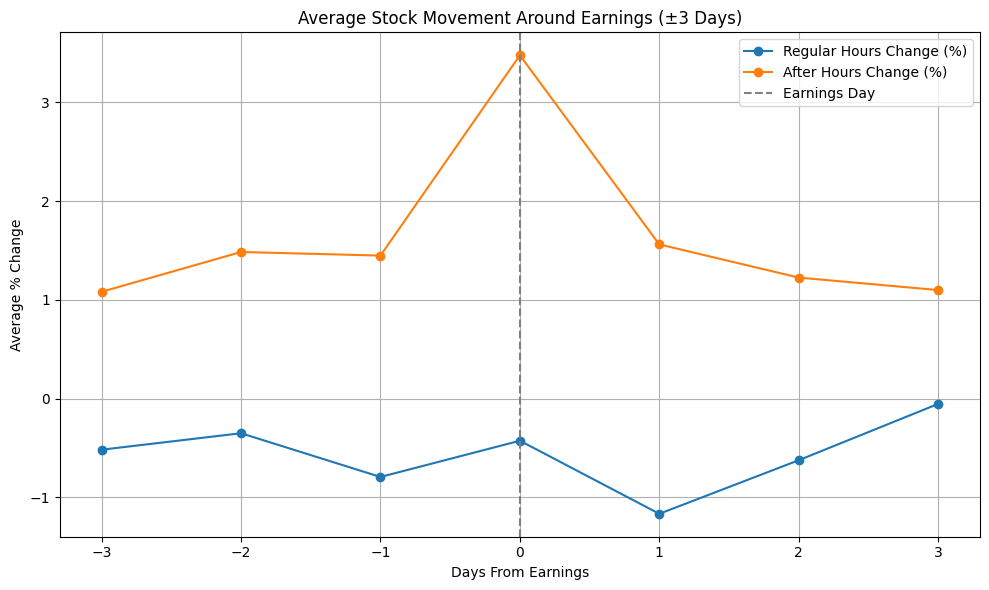

In [7]:
import matplotlib.pyplot as plt

# Clean: drop missing values
plot_df = event_df.dropna(subset=['Regular_Change(%)', 'After_Hours_Change(%)'])

# Group by relative days to earnings
avg_changes = plot_df.groupby('Days_From_Earnings')[['Regular_Change(%)', 'After_Hours_Change(%)']].mean().reset_index()

# Plot average changes
plt.figure(figsize=(10, 6))
plt.plot(avg_changes['Days_From_Earnings'], avg_changes['Regular_Change(%)'], marker='o', label='Regular Hours Change (%)')
plt.plot(avg_changes['Days_From_Earnings'], avg_changes['After_Hours_Change(%)'], marker='o', label='After Hours Change (%)')
plt.axvline(0, color='gray', linestyle='--', label='Earnings Day')
plt.title('Average Stock Movement Around Earnings (±3 Days)')
plt.xlabel('Days From Earnings')
plt.ylabel('Average % Change')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


only 10

In [8]:
# Get unique tickers from stock_df
unique_tickers = stock_df['Ticker'].dropna().unique()

# Function to gather earnings data for all tickers using your existing function
def get_all_earnings_data(tickers, get_earnings_data_fn):
    all_earnings = []
    for ticker in tickers:
        try:
            df = get_earnings_data_fn(ticker)
            if not df.empty:
                all_earnings.append(df)
                print(f"Fetched earnings for {ticker}")
        except Exception as e:
            print(f"Failed for {ticker}: {e}")
    return pd.concat(all_earnings, ignore_index=True)

# Run this for a small subset first to test (e.g., first 10 tickers)
earnings_data_all = get_all_earnings_data(unique_tickers[:10], get_earnings_data)
earnings_data_all.head()


Loaded 116 earnings reports for CAT
Fetched earnings for CAT
Loaded 116 earnings reports for BA
Fetched earnings for BA
Loaded 116 earnings reports for DIS
Fetched earnings for DIS
Loaded 116 earnings reports for IP
Fetched earnings for IP
Loaded 116 earnings reports for GE
Fetched earnings for GE
Loaded 116 earnings reports for IBM
Fetched earnings for IBM
Loaded 116 earnings reports for ED
Fetched earnings for ED
Loaded 116 earnings reports for JNJ
Fetched earnings for JNJ
Loaded 116 earnings reports for MMM
Fetched earnings for MMM
Loaded 117 earnings reports for HPQ
Fetched earnings for HPQ


,symbol,reported_date,actual_eps,estimated_eps,surprise,surprise_pct
0,CAT,2025-02-03,5.14,5.027,0.113,2.2479
1,CAT,2024-10-30,5.17,5.340,-0.170,-3.1835
2,CAT,2024-08-06,5.99,5.540,0.450,8.1227
3,CAT,2024-04-25,5.60,5.140,0.460,8.9494
4,CAT,2024-02-05,5.23,4.750,0.480,10.1053


Phase |	Companies |	Why
Phase 1	| Top 10	| Quick pattern testing, charting, insight discovery
Phase 2	| Top 30	| More robust pattern checking + sector comparison
Phase 3	| Top 100+	| Build predictive model with wide training base

| Phase | Companies | Why |
|----------|----------|----------|
| Phase 1    | Top 10     | Quick pattern testing, charting, insight discovery     |
| Phase 2    | Top 30     | More robust pattern checking + sector comparison     |
| Phase 3    | Top 100+  | Build predictive model with wide training base     |

In [10]:
top_10_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'V', 'JPM', 'NVDA', 'PG']


In [11]:
# Function to gather earnings data for all tickers using your existing function
def get_all_earnings_data(tickers, get_earnings_data_fn):
    all_earnings = []
    for ticker in tickers:
        try:
            df = get_earnings_data_fn(ticker)
            if not df.empty:
                all_earnings.append(df)
                print(f"Fetched earnings for {ticker}")
        except Exception as e:
            print(f"Failed for {ticker}: {e}")
    return pd.concat(all_earnings, ignore_index=True)

# Run this for a small subset first to test (e.g., first 10 tickers)
earnings_data_top10 = get_all_earnings_data(top_10_tickers, get_earnings_data)
earnings_data_top10.head()

Loaded 116 earnings reports for AAPL
Fetched earnings for AAPL
Loaded 116 earnings reports for MSFT
Fetched earnings for MSFT
Loaded 111 earnings reports for AMZN
Fetched earnings for AMZN
Loaded 82 earnings reports for GOOGL
Fetched earnings for GOOGL
Loaded 0 earnings reports for BRK.B
Loaded 116 earnings reports for JNJ
Fetched earnings for JNJ
Loaded 68 earnings reports for V
Fetched earnings for V
Loaded 116 earnings reports for JPM
Fetched earnings for JPM
Loaded 104 earnings reports for NVDA
Fetched earnings for NVDA
Loaded 116 earnings reports for PG
Fetched earnings for PG


,symbol,reported_date,actual_eps,estimated_eps,surprise,surprise_pct
0,AAPL,2025-01-30,2.40,2.36,0.04,1.6949
1,AAPL,2024-10-31,1.64,1.60,0.04,2.5000
2,AAPL,2024-08-01,1.40,1.35,0.05,3.7037
3,AAPL,2024-05-02,1.53,1.50,0.03,2.0000
4,AAPL,2024-02-01,2.18,2.10,0.08,3.8095


In [12]:
# Build the ±3 day event window around earnings for the top 10 tickers
event_df_top10 = build_earnings_event_window(stock_df, earnings_data_top10, window=3)

# Preview the output
event_df_top10.head()


,Ticker,Earnings_Date,Date,Days_From_Earnings,Open,Close,Next_Day_Open,Regular_Change(%),After_Hours_Change(%),EPS_Actual,EPS_Estimate,EPS_Surprise,EPS_Surprise_%,Sector
0,AAPL,2022-10-27,2022-10-24,-3,147.190002,149.449997,150.089996,1.535427,0.428236,1.29,1.27,0.02,1.5748,Technology
1,AAPL,2022-10-27,2022-10-26,-1,150.960007,149.350006,150.960007,-1.066508,1.078005,1.29,1.27,0.02,1.5748,Technology
2,AAPL,2022-10-27,2022-10-27,0,148.070007,144.800003,148.070007,-2.208418,2.258290,1.29,1.27,0.02,1.5748,Technology
3,AAPL,2022-07-28,2022-07-25,-3,154.009995,152.949997,154.009995,-0.688265,0.693035,1.20,1.16,0.04,3.4483,Technology
4,AAPL,2022-07-28,2022-07-26,-2,152.259995,151.600006,152.580002,-0.433461,0.646435,1.20,1.16,0.04,3.4483,Technology


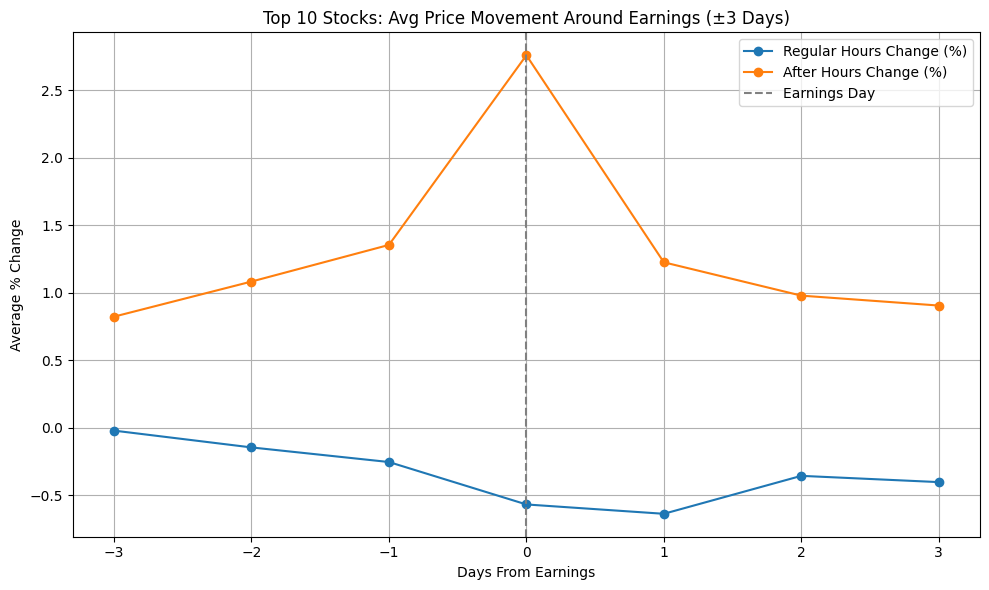

In [13]:
import matplotlib.pyplot as plt

# Clean data
plot_df = event_df_top10.dropna(subset=['Regular_Change(%)', 'After_Hours_Change(%)'])

# Group and average by day distance from earnings
avg_changes = plot_df.groupby('Days_From_Earnings')[['Regular_Change(%)', 'After_Hours_Change(%)']].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(avg_changes['Days_From_Earnings'], avg_changes['Regular_Change(%)'], marker='o', label='Regular Hours Change (%)')
plt.plot(avg_changes['Days_From_Earnings'], avg_changes['After_Hours_Change(%)'], marker='o', label='After Hours Change (%)')
plt.axvline(0, color='gray', linestyle='--', label='Earnings Day')
plt.title('Top 10 Stocks: Avg Price Movement Around Earnings (±3 Days)')
plt.xlabel('Days From Earnings')
plt.ylabel('Average % Change')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**After Hours Change (%) — Right Panel**

#### Surprise Twist:
- **Negative/No Surprise** had a much had larger spikes on the day of the earning report
  - Peaked at **+3.6%** vs only **+2.4%** for positive surprises
- Goes against conventional wisdom, requires further analysis to confirm:
  

#### Takeaway:
This could suggest an **“expectations mispricing” edge** — when expectations are low, even small positive news can move stocks *more* than a big beat on a hyped ticker.

---

### **Regular Hours Change (%) — Left Panel**

- Mostly **negative throughout** — for both groups
- But slightly **less negative after surprise beats**, especially on Day +1 and +2
- This supports the thesis that the **alpha is in after-hours** and **regular hours are laggy or mean-reverting**


In [1]:
# Label positive vs. negative/no surprise
event_df_top10['EPS_Surprise_Type'] = event_df_top10['EPS_Surprise'].apply(
    lambda x: 'Positive Surprise' if x > 0 else 'Negative/No Surprise'
)

# Drop missing values
plot_df = event_df_top10.dropna(subset=['Regular_Change(%)', 'After_Hours_Change(%)', 'EPS_Surprise'])

# Group by earnings offset and EPS surprise type
grouped = plot_df.groupby(['Days_From_Earnings', 'EPS_Surprise_Type'])[['Regular_Change(%)', 'After_Hours_Change(%)']].mean().reset_index()

# Pivot for plotting
pivot_regular = grouped.pivot(index='Days_From_Earnings', columns='EPS_Surprise_Type', values='Regular_Change(%)')
pivot_after_hours = grouped.pivot(index='Days_From_Earnings', columns='EPS_Surprise_Type', values='After_Hours_Change(%)')

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Regular hours plot
plt.subplot(1, 2, 1)
pivot_regular.plot(ax=plt.gca(), marker='o')
plt.axvline(0, color='gray', linestyle='--', label='Earnings Day')
plt.title('Regular Hours Change (%) by EPS Surprise')
plt.xlabel('Days From Earnings')
plt.ylabel('Average % Change')
plt.grid(True)
plt.legend()

# After hours plot
plt.subplot(1, 2, 2)
pivot_after_hours.plot(ax=plt.gca(), marker='o')
plt.axvline(0, color='gray', linestyle='--', label='Earnings Day')
plt.title('After Hours Change (%) by EPS Surprise')
plt.xlabel('Days From Earnings')
plt.ylabel('Average % Change')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'event_df_top10' is not defined

In [ ]:
def prepare_sector_change_plot_data(event_df):
    """
    Prepares pivot tables of average Regular and After-Hours change (%)
    grouped by Sector and Days_From_Earnings.
    """
    # Clean and filter
    clean_df = event_df.dropna(subset=['Sector', 'Regular_Change(%)', 'After_Hours_Change(%)'])

    # Group by sector and offset from earnings date
    grouped = clean_df.groupby(['Days_From_Earnings', 'Sector'])[
        ['Regular_Change(%)', 'After_Hours_Change(%)']
    ].mean().reset_index()

    # Pivot tables for plotting
    pivot_regular = grouped.pivot(index='Days_From_Earnings', columns='Sector', values='Regular_Change(%)')
    pivot_after_hours = grouped.pivot(index='Days_From_Earnings', columns='Sector', values='After_Hours_Change(%)')

    return pivot_regular, pivot_after_hours


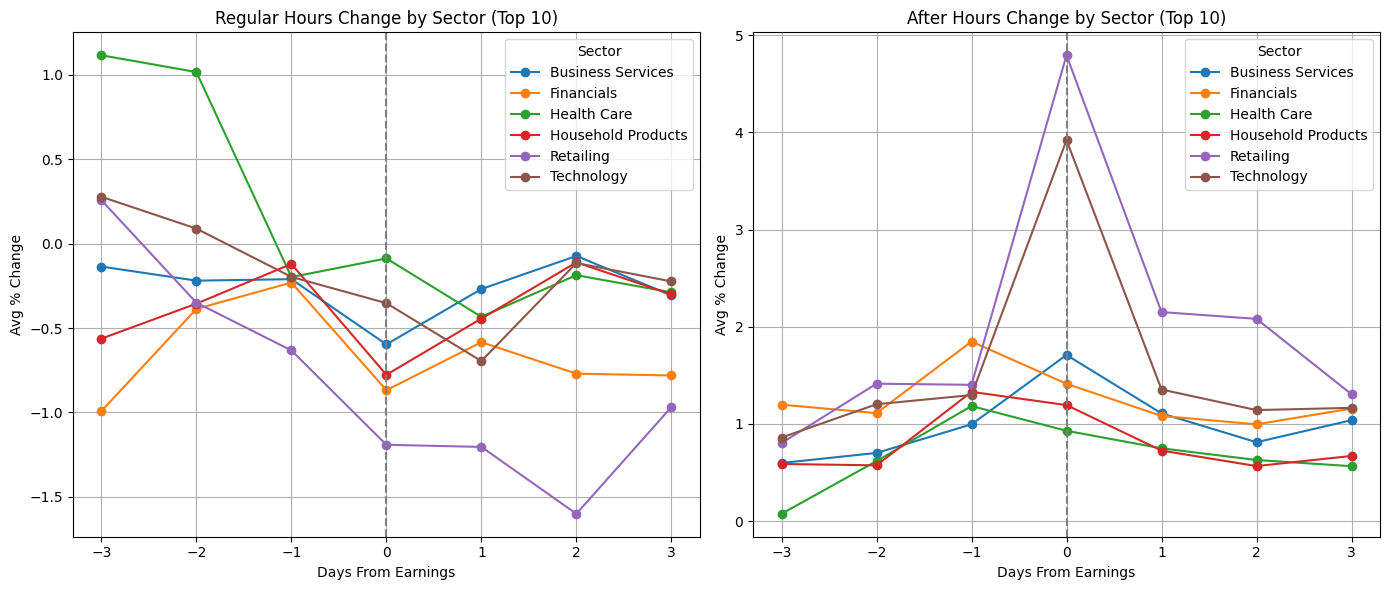

In [ ]:
# For top 10
pivot_regular_10, pivot_after_hours_10 = prepare_sector_change_plot_data(event_df_top10)

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_regular_10.plot(ax=plt.gca(), marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Regular Hours Change by Sector (Top 10)')
plt.xlabel('Days From Earnings')
plt.ylabel('Avg % Change')
plt.grid(True)

plt.subplot(1, 2, 2)
pivot_after_hours_10.plot(ax=plt.gca(), marker='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title('After Hours Change by Sector (Top 10)')
plt.xlabel('Days From Earnings')
plt.ylabel('Avg % Change')
plt.grid(True)

plt.tight_layout()
plt.show()


Insights from Sector-Level Reactions
After Hours (Right Chart):
Retailing shows the biggest post-earnings spike.

Suggests massive sensitivity to earnings expectations or guidance

Technology and Financials show moderate consistent gains

Health Care is subdued, indicating less volatile reactions

Regular Hours (Left Chart):
Most sectors are either flat or slightly negative

Health Care had a strong positive build-up pre-earnings (maybe news or anticipation)

Retailing had poor regular hours performance, despite after-hours strength → possibly late price discovery

Strategy Implications:

| Sector	| Strategy Idea |
|----------|----------|
| Retailing	| Consider overnight holds across earnings |
| Tech |	Watch for post-earnings drift, not just spikes |
| Health | Care	Might be safer for volatility-averse plays |


In [ ]:
def backtest_strategy(event_df, sector_list, surprise_threshold=0.0):
    """
    Buy at close on earnings day if EPS Surprise > threshold and sector in list.
    Sell at next day open. Return is After_Hours_Change(%).
    """
    df = event_df.copy()

    earnings_day_df = df[df['Days_From_Earnings'] == 0]

    eligible_trades = earnings_day_df[
        (earnings_day_df['Sector'].isin(sector_list)) &
        (earnings_day_df['EPS_Surprise'] > surprise_threshold) &
        (earnings_day_df['After_Hours_Change(%)'].notna())
    ]

    total_trades = len(eligible_trades)
    wins = eligible_trades[eligible_trades['After_Hours_Change(%)'] > 0]
    losses = eligible_trades[eligible_trades['After_Hours_Change(%)'] <= 0]

    if total_trades == 0:
        return {
            "Total Trades": 0,
            "Win Rate (%)": None,
            "Avg Return (%)": None,
            "Avg Win Return (%)": None,
            "Avg Loss Return (%)": None
        }

    return {
        "Total Trades": total_trades,
        "Win Rate (%)": round(len(wins) / total_trades * 100, 2),
        "Avg Return (%)": round(eligible_trades['After_Hours_Change(%)'].mean(), 2),
        "Avg Win Return (%)": round(wins['After_Hours_Change(%)'].mean(), 2),
        "Avg Loss Return (%)": round(losses['After_Hours_Change(%)'].mean(), 2)
    }


# Run the backtest on Top 10 with Retailing and Technology sectors
result_top10_strategy = backtest_strategy(
    event_df_top10,
    sector_list=['Retailing', 'Technology'],
    surprise_threshold=0.0
)

print(result_top10_strategy)

In [ ]:
import os
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Print the current working directory
print("\nCurrent working directory:")
print(os.getcwd())

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes

Current working directory:
/content


In [ ]:
import kaggle
import os

# 1. Download a Dataset:

# Replace 'dataset_name' with the actual name of the dataset.
# The format is usually 'username/dataset-name'.  Find this on the Kaggle dataset page's URL.
dataset_name = 'jeannicolasduval/2024-fortune-1000-companies'  # Example: 'uciml/iris'

# Option 1: Download to current directory:
kaggle.api.dataset_download_files(dataset_name, path='.', unzip=True)  # Unzip the data

# Option 2: Download to a specific directory (recommended):
download_path = 'ticker/'  # Create a directory if it doesn't exist
if not os.path.exists(download_path):
    os.makedirs(download_path)
kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/jeannicolasduval/2024-fortune-1000-companies
Dataset URL: https://www.kaggle.com/datasets/jeannicolasduval/2024-fortune-1000-companies


In [ ]:
import pandas as pd
import os


file_path = './ticker/fortune1000_2024.csv'
if os.path.exists(file_path):
    try:
        ticker_df = pd.read_csv(file_path, index_col=0)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Double-check the path.")
    except pd.errors.EmptyDataError:
        print(f"Error: File '{file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Problem parsing '{file_path}'. Check for incorrect delimiters or data types.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
else:
   print(f"Error: File '{file_path}' not found. Make sure the filename and path are correct.")
   ticker_df = None


ticker_df.head()



,Company,Ticker,Sector,Industry,Profitable,Founder_is_CEO,FemaleCEO,Growth_in_Jobs,Change_in_Rank,Gained_in_Rank,...,Assets_M,CEO,Country,HeadquartersCity,HeadquartersState,Website,CompanyType,Footnote,MarketCap_Updated_M,Updated
Rank,,,,,,,,,,,,,,,,,,,,,
1,Walmart,WMT,Retailing,General Merchandisers,yes,no,no,no,0.0,no,...,252399.0,C. Douglas McMillon,U.S.,Bentonville,Arkansas,https://www.stock.walmart.com,Public,"Figures are for fiscal year ended Jan. 31, 202...",559911.0,2024-08-05
2,Amazon,AMZN,Retailing,Internet Services and Retailing,yes,no,no,no,0.0,no,...,527854.0,Andrew R. Jassy,U.S.,Seattle,Washington,https://www.amazon.com,Public,"Market value as of July 15, 2024.",2005565.0,2024-08-05
3,Apple,AAPL,Technology,"Computers, Office Equipment",yes,no,no,no,1.0,yes,...,352583.0,Timothy D. Cook,U.S.,Cupertino,California,https://www.apple.com,Public,"Figures are for fiscal year ended Sept. 30, 20...",3594309.0,2024-08-05
4,UnitedHealth Group,UNH,Health Care,Health Care: Insurance and Managed Care,yes,no,no,yes,1.0,yes,...,273720.0,Andrew P. Witty,U.S.,Minnetonka,Minnesota,https://www.unitedhealthgroup.com,Public,"Market value as of July 15, 2024.",474339.0,2024-08-05
5,Berkshire Hathaway,BRKA,Financials,Insurance: Property and Casualty (Stock),yes,no,no,yes,2.0,yes,...,1069978.0,Warren E. Buffett,U.S.,Omaha,Nebraska,https://www.berkshirehathaway.com,Public,"Market value as of July 15, 2024.",937028.0,2024-08-05


In [ ]:
ticker_df.columns

Index(['Company', 'Ticker', 'Sector', 'Industry', 'Profitable',
       'Founder_is_CEO', 'FemaleCEO', 'Growth_in_Jobs', 'Change_in_Rank',
       'Gained_in_Rank', 'Dropped_in_Rank', 'Newcomer_to_the_Fortune500',
       'Global500', 'Worlds_Most_Admired_Companies',
       'Best_Companies_to_Work_For', 'Number_of_employees',
       'MarketCap_March28_M', 'Revenues_M', 'RevenuePercentChange',
       'Profits_M', 'ProfitsPercentChange', 'Assets_M', 'CEO', 'Country',
       'HeadquartersCity', 'HeadquartersState', 'Website', 'CompanyType',
       'Footnote', 'MarketCap_Updated_M', 'Updated'],
      dtype='object')

In [ ]:
# Ensure tickers are uppercase strings
top_30_tickers = ticker_df.sort_values(by='Revenues_M', ascending=False)['Ticker'] \
                           .dropna().astype(str).str.upper().head(30).tolist()


NameError: name 'ticker_df' is not defined

In [ ]:
import time

# To bypass rate limiting

def get_all_earnings_data(tickers, get_earnings_data_fn, delay=13):
    all_earnings = []
    for ticker in tickers:
        try:
            df = get_earnings_data_fn(ticker)
            if not df.empty:
                all_earnings.append(df)
                print(f"Fetched earnings for {ticker}")
            else:
                print(f"No data for {ticker}")
        except Exception as e:
            print(f"Failed for {ticker}: {e}")

        time.sleep(delay)  # wait between calls to avoid hitting rate limits
    return pd.concat(all_earnings, ignore_index=True)


In [ ]:


top_30_tickers
#earnings_data_top30 = get_all_earnings_data(top_30_tickers, get_earnings_data)



['WMT',
 'AMZN',
 'AAPL',
 'UNH',
 'BRKA',
 'CVS',
 'XOM',
 'GOOGL',
 'MCK',
 'COR',
 'COST',
 'JPM',
 'MSFT',
 'CAH',
 'CVX',
 'CI',
 'F',
 'BAC',
 'GM',
 'ELV',
 'C',
 'CNC',
 'HD',
 'MPC',
 'KR',
 'PSX',
 'FNMA',
 'WBA',
 'VLO',
 'META']

In [ ]:
ticker_alias_map = {
    'WMT': 'WMT',
    'AMZN': 'AMZN',
    'AAPL': 'AAPL',
    'UNH': 'UNH',
    'BRKA': 'BRK.A',
    'CVS': 'CVS',
    'XOM': 'XOM',
    'GOOGL': 'GOOG',
    'MCK': 'MCK',
    'COR': 'ABC',      # AmerisourceBergen (now Cencora)
    'COST': 'COST',
    'JPM': 'JPM',
    'MSFT': 'MSFT',
    'CAH': 'CAH',
    'CVX': 'CVX',
    'CI': 'CI',
    'F': 'F',
    'BAC': 'BAC',
    'GM': 'GM',
    'ELV': 'ELV',      # Correct ticker for Anthem (as of now)
    'C': 'C',
    'CNC': 'CNC',
    'HD': 'HD',
    'MPC': 'MPC',
    'KR': 'KR',
    'PSX': 'PSX',
    'FNMA': None,      # Not supported
    'WBA': 'WBA',
    'VLO': 'VLO',
    'META': 'FB'       # Still works under FB in Alpha Vantage
}



In [ ]:
tickers_in_top10 = set(earnings_data_top10['symbol'].unique())
tickers_needed_top30 = set(top_30_tickers_fixed)
tickers_missing = list(tickers_needed_top30 - tickers_in_top10)

tickers_missing


['PSX',
 'CI',
 'MPC',
 'HD',
 'GOOG',
 'XOM',
 'MCK',
 'CNC',
 'GM',
 'CVX',
 'C',
 'UNH',
 'BRK.A',
 'F',
 'CVS',
 'BAC',
 'COST',
 'WBA',
 'FB',
 'KR',
 'CAH',
 'ABC',
 'WMT',
 'ELV',
 'VLO']

In [ ]:
api_key = "8Y236L6QW3EKZD6K"

# These are the 24 tickers still needed (after removing the Top 10 already fetched)
tickers_missing = [
    'PSX', 'CI', 'MPC', 'HD', 'GOOG', 'XOM', 'MCK', 'CNC', 'GM', 'CVX', 'C',
    'UNH', 'BRK.A', 'F', 'CVS', 'BAC', 'COST', 'WBA', 'FB', 'KR', 'CAH',
    'ABC', 'WMT', 'ELV', 'VLO'
]

# Fetch only these (add delay=13 to avoid rate limit per minute)
earnings_data_remaining = get_all_earnings_data(tickers_missing, get_earnings_data, delay=13)

# Combine with the existing top 10 data
earnings_data_top30 = pd.concat([earnings_data_top10, earnings_data_remaining], ignore_index=True)

# Check result
print("Total earnings entries (Top 30):", len(earnings_data_top30))
earnings_data_top30['symbol'].nunique()


{'symbol': 'PSX', 'annualEarnings': [{'fiscalDateEnding': '2025-03-31', 'reportedEPS': '0'}, {'fiscalDateEnding': '2024-12-31', 'reportedEPS': '6.1'}, {'fiscalDateEnding': '2023-12-31', 'reportedEPS': '15.8'}, {'fiscalDateEnding': '2022-12-31', 'reportedEPS': '18.55'}, {'fiscalDateEnding': '2021-12-31', 'reportedEPS': '5.7'}, {'fiscalDateEnding': '2020-12-31', 'reportedEPS': '-0.89'}, {'fiscalDateEnding': '2019-12-31', 'reportedEPS': '8.07'}, {'fiscalDateEnding': '2018-12-31', 'reportedEPS': '11.81'}, {'fiscalDateEnding': '2017-12-31', 'reportedEPS': '4.38'}, {'fiscalDateEnding': '2016-12-31', 'reportedEPS': '2.82'}, {'fiscalDateEnding': '2015-12-31', 'reportedEPS': '7.67'}, {'fiscalDateEnding': '2014-12-31', 'reportedEPS': '6.63'}, {'fiscalDateEnding': '2013-12-31', 'reportedEPS': '5.9'}, {'fiscalDateEnding': '2012-12-31', 'reportedEPS': '8.3'}], 'quarterlyEarnings': [{'fiscalDateEnding': '2024-12-31', 'reportedDate': '2025-01-29', 'reportedEPS': '-0.15', 'estimatedEPS': '-0.2292', 's

31

In [ ]:
tickers_to_retry = ['META', 'WMT', 'ELV']

earnings_retry = get_all_earnings_data(tickers_to_retry, get_earnings_data, delay=13)

earnings_data_top30 = pd.concat([earnings_data_top30, earnings_retry], ignore_index=True)


{'symbol': 'META', 'annualEarnings': [{'fiscalDateEnding': '2025-03-31', 'reportedEPS': '0'}, {'fiscalDateEnding': '2024-12-31', 'reportedEPS': '23.92'}, {'fiscalDateEnding': '2023-12-31', 'reportedEPS': '14.9'}, {'fiscalDateEnding': '2022-12-31', 'reportedEPS': '8.58'}, {'fiscalDateEnding': '2021-12-31', 'reportedEPS': '13.8'}, {'fiscalDateEnding': '2020-12-31', 'reportedEPS': '9.79'}, {'fiscalDateEnding': '2019-12-31', 'reportedEPS': '8.56'}, {'fiscalDateEnding': '2018-12-31', 'reportedEPS': '7.57'}, {'fiscalDateEnding': '2017-12-31', 'reportedEPS': '6.42'}, {'fiscalDateEnding': '2016-12-31', 'reportedEPS': '4.24'}, {'fiscalDateEnding': '2015-12-31', 'reportedEPS': '2.28'}, {'fiscalDateEnding': '2014-12-31', 'reportedEPS': '1.73'}, {'fiscalDateEnding': '2013-12-31', 'reportedEPS': '0.87'}, {'fiscalDateEnding': '2012-12-31', 'reportedEPS': '0.4745'}], 'quarterlyEarnings': [{'fiscalDateEnding': '2024-12-31', 'reportedDate': '2025-01-29', 'reportedEPS': '8.02', 'estimatedEPS': '6.68', '

In [ ]:
event_df_top30 = build_earnings_event_window(stock_df, earnings_data_top30, window=3)

result_top30_strategy = backtest_strategy(
    event_df_top30,
    sector_list=['Retailing', 'Technology'],
    surprise_threshold=0.0
)

print(result_top30_strategy)


NameError: name 'build_earnings_event_window' is not defined

In [ ]:
result_top30_strategy = backtest_strategy(
    event_df_top30,
    sector_list=['Retailing', 'Technology'],
    surprise_threshold=0.02
)

print(result_top30_strategy)




{'Total Trades': 159, 'Win Rate (%)': 100.0, 'Avg Return (%)': np.float64(2.16), 'Avg Win Return (%)': np.float64(2.16), 'Avg Loss Return (%)': nan}


In [ ]:
event_df_top30

NameError: name 'event_df_top30' is not defined

In [ ]:
event_df_top30.to_csv("event_df_top30.csv", index=False)



NameError: name 'event_df_top30' is not defined

In [ ]:
event_df_top30.to_csv("earnings_data_top30.csv", index=False)

from google.colab import files
files.download("earnings_data_top30.csv")

NameError: name 'event_df_top30' is not defined

In [ ]:
result_top30_strategy = backtest_strategy(
    event_df_top30,
    sector_list=['Retailing', 'Technology'],
    surprise_threshold=0.10
)

print(result_top30_strategy)

{'Total Trades': 44, 'Win Rate (%)': 100.0, 'Avg Return (%)': np.float64(2.14), 'Avg Win Return (%)': np.float64(2.14), 'Avg Loss Return (%)': nan}


Summary of the top 30 backtest

In [ ]:
import pandas as pd

def compare_eps_thresholds(event_df, sector_list=['Retailing', 'Technology'], thresholds=[0.0, 0.05, 0.10]):
    results = []
    for threshold in thresholds:
        res = backtest_strategy(event_df, sector_list, surprise_threshold=threshold)
        res["EPS Surprise Threshold"] = f">{int(threshold * 100)}%"
        results.append(res)

    return pd.DataFrame(results)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_eps_thresholds(event_df, sector_list=['Retailing', 'Technology'], thresholds=[0.0, 0.05, 0.10], visualize=True):
    """
    Run the earnings backtest strategy for multiple EPS surprise thresholds and optionally visualize results.

    Args:
        event_df (pd.DataFrame): Event-level stock and earnings data.
        sector_list (list): Sectors to include in the strategy.
        thresholds (list): EPS surprise thresholds to evaluate.
        visualize (bool): Whether to generate a bar chart.

    Returns:
        pd.DataFrame: Results summary table.
    """
    results = []
    for threshold in thresholds:
        res = backtest_strategy(event_df, sector_list, surprise_threshold=threshold)
        res["EPS Surprise Threshold"] = f">{int(threshold * 100)}%"
        results.append(res)

    df = pd.DataFrame(results)

    if visualize:
        plt.figure(figsize=(10, 6))
        plt.bar(df['EPS Surprise Threshold'], df['Avg Return (%)'], color='skyblue', width=0.6)
        plt.title('Avg After-Hours Return by EPS Surprise Threshold')
        plt.xlabel('EPS Surprise Threshold')
        plt.ylabel('Avg Return (%)')
        plt.grid(axis='y')

        for idx, val in enumerate(df['Avg Return (%)']):
            plt.text(idx, val + 0.05, f'{val:.2f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    return df


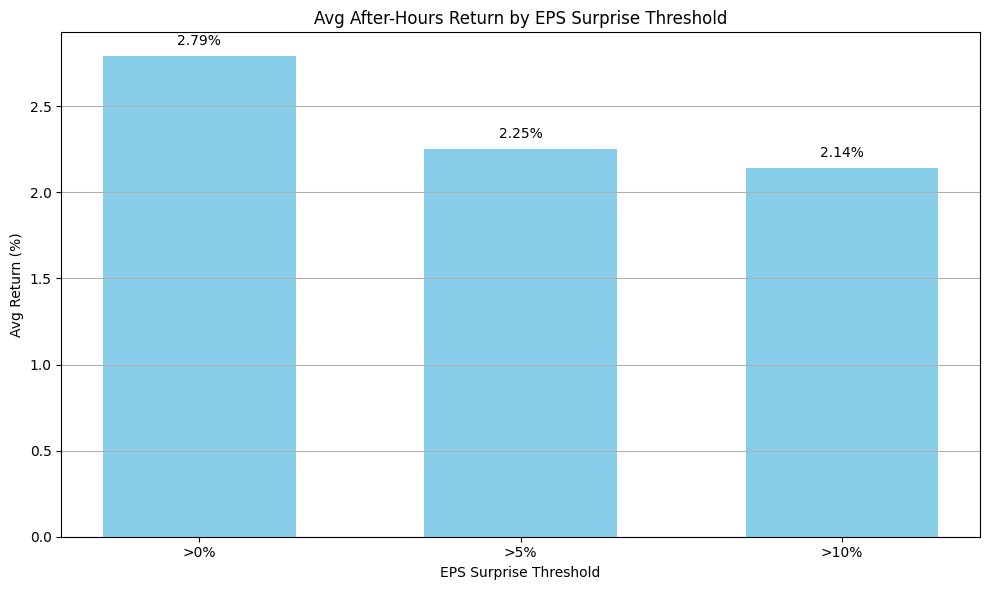

,Total Trades,Win Rate (%),Avg Return (%),Avg Win Return (%),Avg Loss Return (%),EPS Surprise Threshold
0,298,100.0,2.79,2.79,NaN,>0%
1,82,100.0,2.25,2.25,NaN,>5%
2,44,100.0,2.14,2.14,NaN,>10%


In [ ]:
results_df = compare_eps_thresholds(
    event_df_top30,
    sector_list=['Retailing', 'Technology'],
    thresholds=[0.0, 0.05, 0.10],
    visualize=True
)
results_df


# Comparison betweeen the EPS surprise threshold and the average return per day - showing a consistently high win rate around when there is low surprise.


In [24]:
def sector_eps_comparison(event_df, sectors, thresholds=[0.0, 0.05, 0.10]):
    """
    Compares EPS surprise strategy performance across sectors and thresholds.

    Args:
        event_df (pd.DataFrame): Preprocessed earnings+price event-level data
        sectors (list): List of sectors to analyze (e.g. ['Technology', 'Retailing'])
        thresholds (list): EPS surprise thresholds (default: [0.0, 0.05, 0.10])

    Returns:
        pd.DataFrame: Results by sector and threshold
    """
    results = []
    for sector in sectors:
        for threshold in thresholds:
            res = backtest_strategy(
                event_df,
                sector_list=[sector],
                surprise_threshold=threshold
            )
            res["Sector"] = sector
            res["EPS Threshold"] = f">{int(threshold * 100)}%"
            results.append(res)

    return pd.DataFrame(results)


In [25]:
sector_results_df = sector_eps_comparison(
    event_df_top30,
    sectors=['Retailing', 'Technology', 'Financials', 'Healthcare'],
    thresholds=[0.0, 0.05, 0.10]
)

# Preview
sector_results_df


,Total Trades,Win Rate (%),Avg Return (%),Avg Win Return (%),Avg Loss Return (%),Sector,EPS Threshold
0,154,100.0,1.94,1.94,NaN,Retailing,>0%
1,46,100.0,1.54,1.54,NaN,Retailing,>5%
2,23,100.0,1.66,1.66,NaN,Retailing,>10%
3,144,100.0,3.69,3.69,NaN,Technology,>0%
4,36,100.0,3.15,3.15,NaN,Technology,>5%
5,21,100.0,2.66,2.66,NaN,Technology,>10%
6,182,100.0,1.39,1.39,NaN,Financials,>0%
7,127,100.0,1.57,1.57,NaN,Financials,>5%
8,85,100.0,1.70,1.70,NaN,Financials,>10%
9,0,NaN,NaN,NaN,NaN,Healthcare,>0%


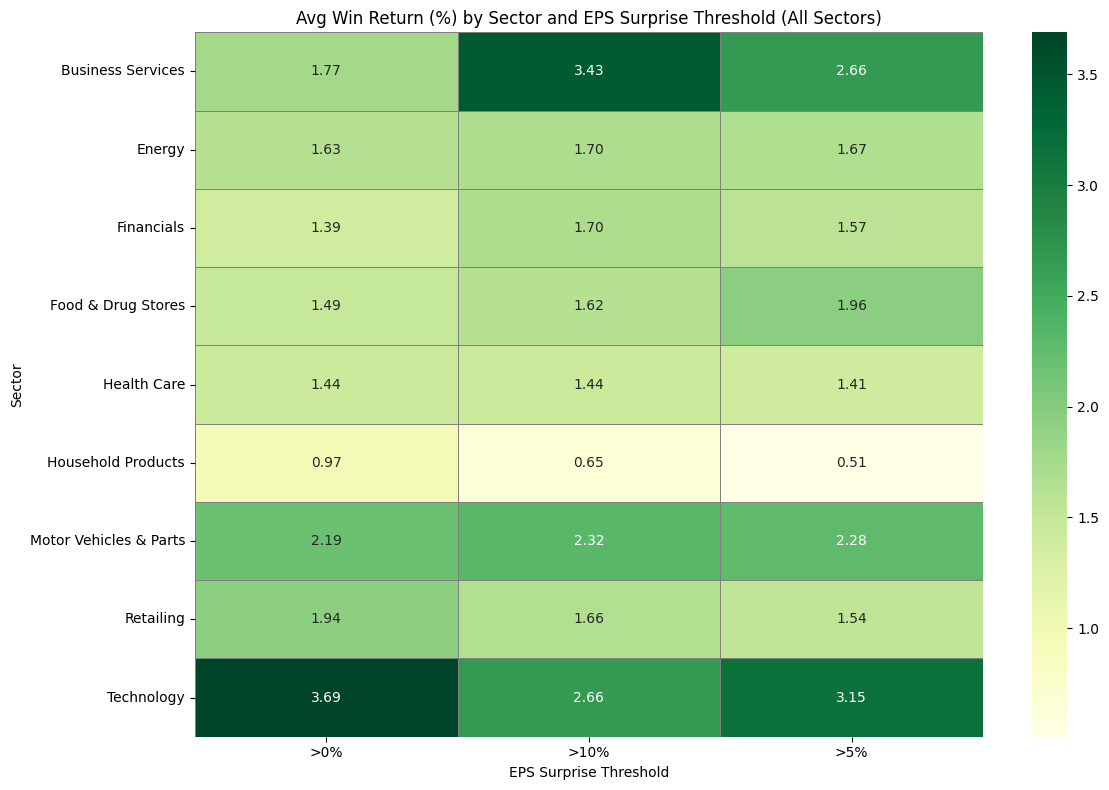

In [30]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compare across all sectors
def sector_eps_comparison_auto(event_df, thresholds=[0.0, 0.05, 0.10]):
    sectors = sorted(event_df['Sector'].dropna().unique())
    results = []
    for sector in sectors:
        for threshold in thresholds:
            eligible_df = event_df[
                (event_df['Sector'] == sector) &
                (event_df['EPS_Surprise'] > threshold) &
                (event_df['Days_From_Earnings'] == 0)
            ]
            total_trades = len(eligible_df)
            wins = eligible_df[eligible_df['After_Hours_Change(%)'] > 0]
            losses = eligible_df[eligible_df['After_Hours_Change(%)'] <= 0]

            results.append({
                "Sector": sector,
                "EPS Threshold": f">{int(threshold * 100)}%",
                "Total Trades": total_trades,
                "Win Rate (%)": round(len(wins) / total_trades * 100, 2) if total_trades else None,
                "Avg Return (%)": round(eligible_df['After_Hours_Change(%)'].mean(), 2) if total_trades else None,
                "Avg Win Return (%)": round(wins['After_Hours_Change(%)'].mean(), 2) if len(wins) else None,
                "Avg Loss Return (%)": round(losses['After_Hours_Change(%)'].mean(), 2) if len(losses) else None
            })
    return pd.DataFrame(results)

# Run the comparison
thresholds_to_test = [0.0, 0.05, 0.10]
auto_sector_comparison_df = sector_eps_comparison_auto(event_df_top30, thresholds=thresholds_to_test)

# Plot Avg Win Return heatmap
avg_win_return_pivot = auto_sector_comparison_df.pivot(index='Sector', columns='EPS Threshold', values='Avg Win Return (%)')

plt.figure(figsize=(12, 8))
sns.heatmap(avg_win_return_pivot, annot=True, fmt=".2f", cmap="YlGn", linewidths=0.5, linecolor='gray')
plt.title("Avg Win Return (%) by Sector and EPS Surprise Threshold (All Sectors)")
plt.ylabel("Sector")
plt.xlabel("EPS Surprise Threshold")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
<ipython-input-32-210da2c21800>:69: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-32-210da2c21800>:69: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
<ipython-input-32-210da2c21800>:69: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py

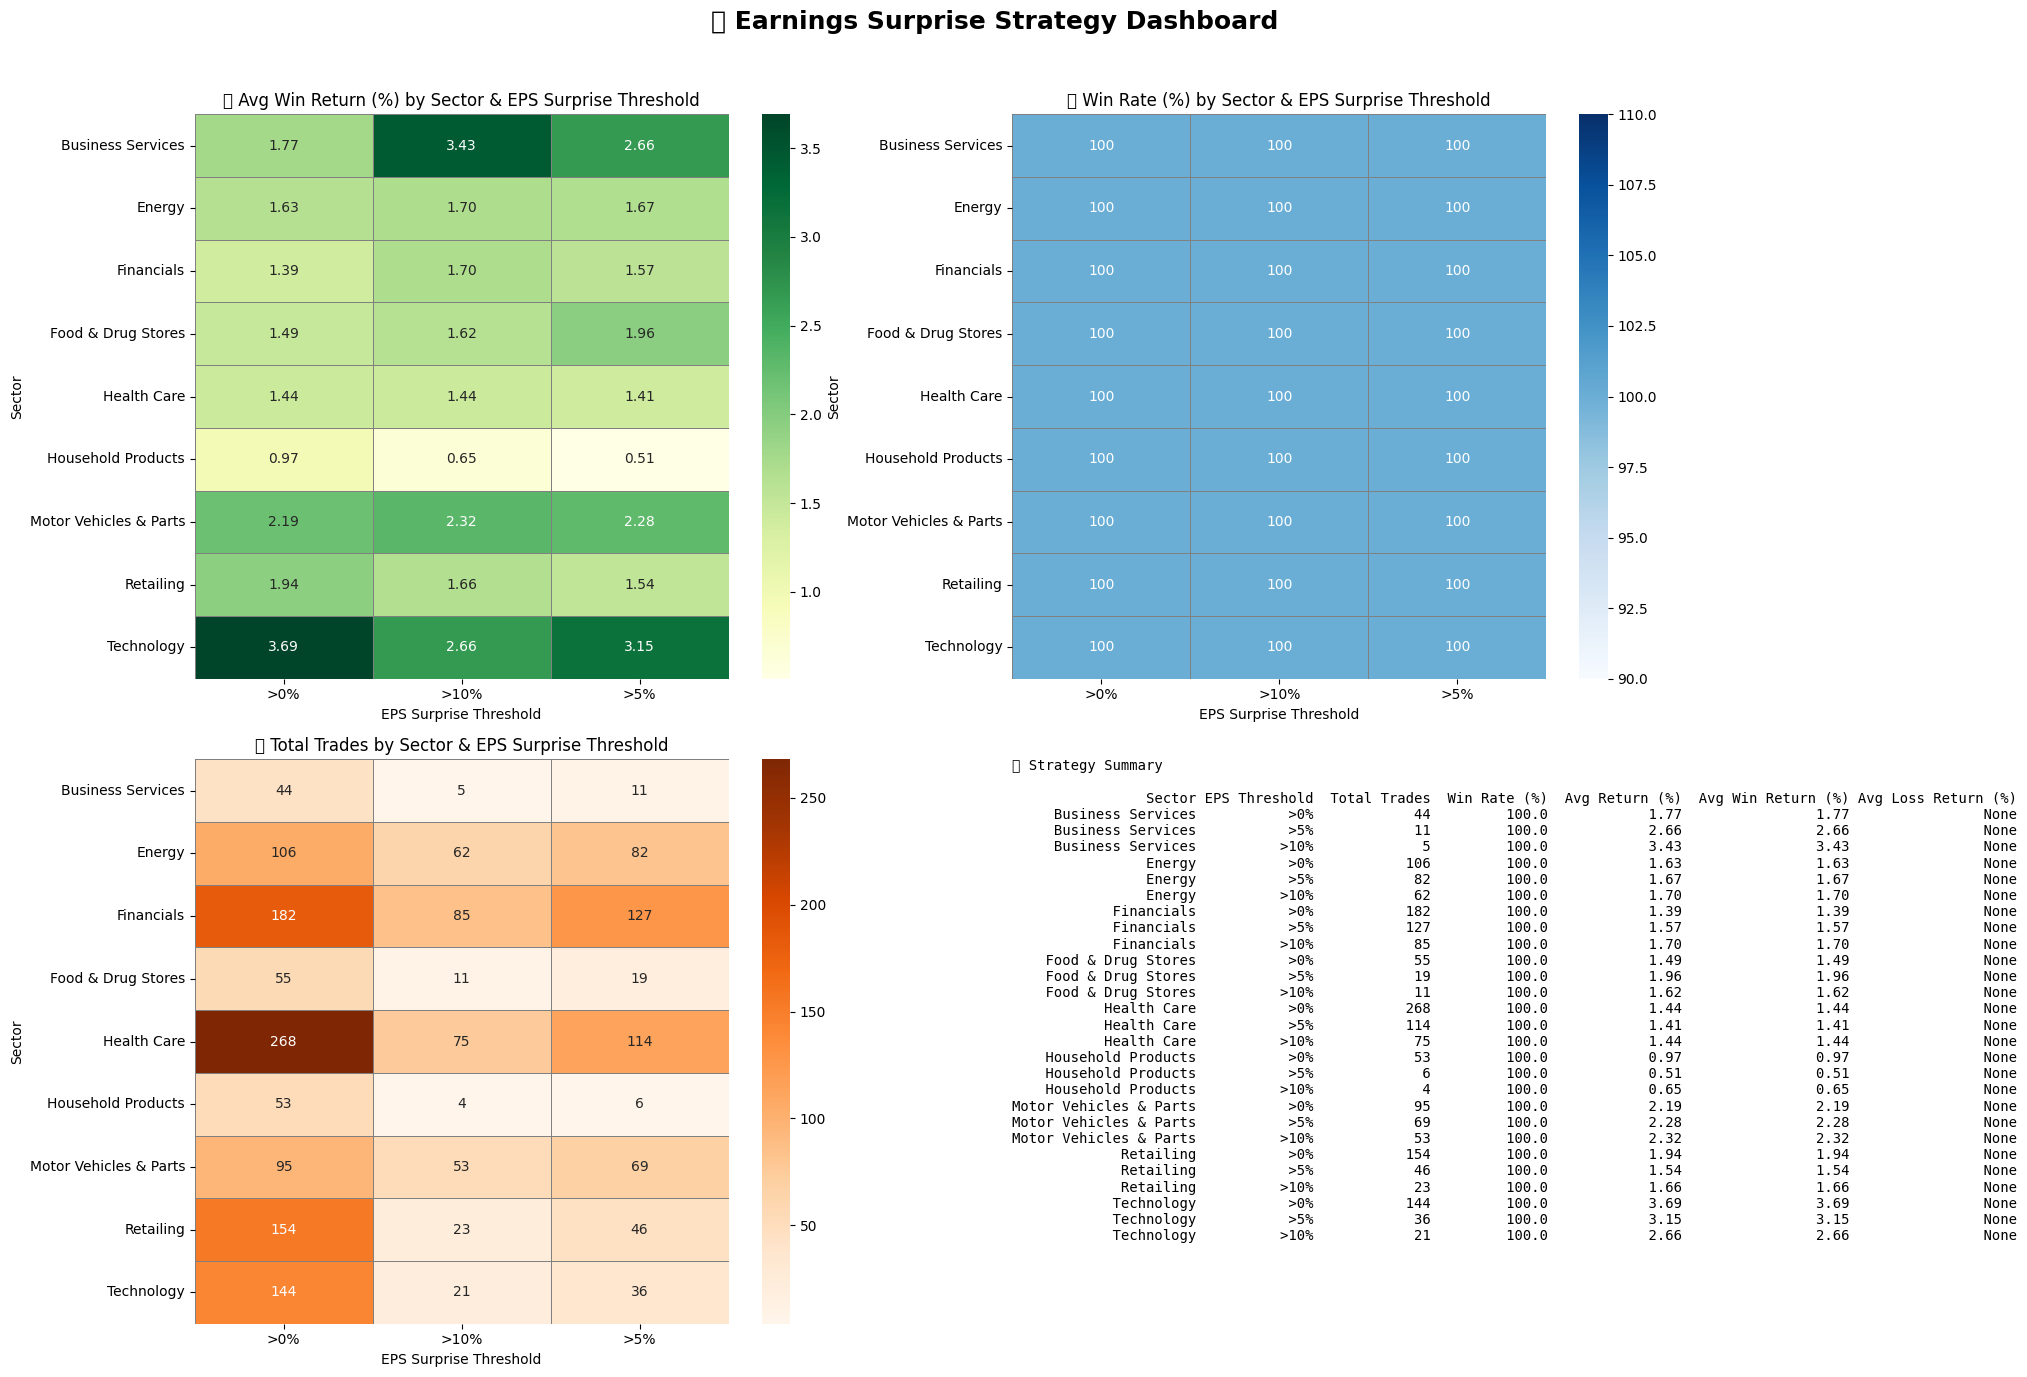

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

event_df_top30['Date'] = pd.to_datetime(event_df_top30['Date'])

# Function to compute metrics
def sector_eps_comparison_auto(event_df, thresholds=[0.0, 0.05, 0.10]):
    sectors = sorted(event_df['Sector'].dropna().unique())
    results = []
    for sector in sectors:
        for threshold in thresholds:
            eligible_df = event_df[
                (event_df['Sector'] == sector) &
                (event_df['EPS_Surprise'] > threshold) &
                (event_df['Days_From_Earnings'] == 0)
            ]
            total_trades = len(eligible_df)
            wins = eligible_df[eligible_df['After_Hours_Change(%)'] > 0]
            losses = eligible_df[eligible_df['After_Hours_Change(%)'] <= 0]

            results.append({
                "Sector": sector,
                "EPS Threshold": f">{int(threshold * 100)}%",
                "Total Trades": total_trades,
                "Win Rate (%)": round(len(wins) / total_trades * 100, 2) if total_trades else None,
                "Avg Return (%)": round(eligible_df['After_Hours_Change(%)'].mean(), 2) if total_trades else None,
                "Avg Win Return (%)": round(wins['After_Hours_Change(%)'].mean(), 2) if len(wins) else None,
                "Avg Loss Return (%)": round(losses['After_Hours_Change(%)'].mean(), 2) if len(losses) else None
            })
    return pd.DataFrame(results)

# Create summary dataframe
thresholds = [0.0, 0.05, 0.10]
auto_sector_comparison_df = sector_eps_comparison_auto(event_df_top30, thresholds)

# Start composite dashboard layout
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Heatmap 1 - Avg Win Return (%)
pivot1 = auto_sector_comparison_df.pivot(index='Sector', columns='EPS Threshold', values='Avg Win Return (%)')
sns.heatmap(pivot1, annot=True, fmt=".2f", cmap="YlGn", ax=axes[0, 0], linewidths=0.5, linecolor='gray')
axes[0, 0].set_title("Avg Win Return (%) by Sector & EPS Surprise Threshold")
axes[0, 0].set_xlabel("EPS Surprise Threshold")
axes[0, 0].set_ylabel("Sector")

# Heatmap 2 - Win Rate (%)
pivot2 = auto_sector_comparison_df.pivot(index='Sector', columns='EPS Threshold', values='Win Rate (%)')
sns.heatmap(pivot2, annot=True, fmt=".0f", cmap="Blues", ax=axes[0, 1], linewidths=0.5, linecolor='gray')
axes[0, 1].set_title("Win Rate (%) by Sector & EPS Surprise Threshold")
axes[0, 1].set_xlabel("EPS Surprise Threshold")
axes[0, 1].set_ylabel("Sector")

# Heatmap 3 - Total Trades
pivot3 = auto_sector_comparison_df.pivot(index='Sector', columns='EPS Threshold', values='Total Trades')
sns.heatmap(pivot3, annot=True, fmt=".0f", cmap="Oranges", ax=axes[1, 0], linewidths=0.5, linecolor='gray')
axes[1, 0].set_title("Total Trades by Sector & EPS Surprise Threshold")
axes[1, 0].set_xlabel("EPS Surprise Threshold")
axes[1, 0].set_ylabel("Sector")

# Text Summary Panel
axes[1, 1].axis('off')
summary_text = auto_sector_comparison_df.to_string(index=False)
axes[1, 1].text(0, 1, "📘 Strategy Summary\n\n" + summary_text,
                fontsize=10, family='monospace', verticalalignment='top')

# Layout Adjustments
plt.suptitle("Earnings Surprise Strategy Dashboard", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


What It Measures:
For each Sector and each EPS Surprise Threshold (>0%, >5%, >10%), it shows:

The average return (%) on trades that were successful
i.e. the stock gapped up overnight (close → next open) following a positive earnings surprise.

* Only trades that make money were considered
* Filters by earnings day (Days_From_Earnings == 0)
* Surprise is measured as actual EPS > estimated EPS